# Pytorch starter - FasterRCNN Train

You can find the [inference notebook here](https://kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-inference)

- FasterRCNN from torchvision
- Uses Resnet50 backbone
- Albumentation enabled (flip + shift-scale-rotate)
- Original Dicom Images (resized by faster-rcnn)
- No validation yet

I trained the latest version (LB: 0.91) on my local machine; the settings were the same as in this notebook (v12).

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())


c:\Users\wew12\Anaconda3\envs\pytorch110_p38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.0
0.11.0
True


# convert_to_coco(data_coco 있으면 pass)

In [34]:
# split_data.py

from glob import glob
import shutil
import os
import random


load_dir = '/home/ubuntu/lesionData/data'
save_dir = '/home/ubuntu/lesionData/data_split'

files = glob('%s/train/*.json' % load_dir)
random.shuffle(files)

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

shutil.copyfile('%s/class_id_info.csv' % load_dir, "%s/class_id_info.csv" % save_dir)
shutil.copyfile('%s/sample_submission.csv' % load_dir, "%s/sample_submission.csv" % save_dir)
shutil.copytree("%s/test" % load_dir, "%s/test" % save_dir)

num_all = len(files)
num_valid = round(0.1 * num_all)

ind = 0
for file in files:
    if ind < num_all - num_valid:
        shutil.copyfile(file, "%s/train/%s" % (save_dir, os.path.basename(file)))
    else:
        shutil.copyfile(file, "%s/valid/%s" % (save_dir, os.path.basename(file)))
    ind += 1
    

In [ ]:
# convert_to_coco.py
# basic setup
import numpy as np
import json
import base64
import os
import random
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

from collections import defaultdict

#base_dir = '/home/ubuntu/lesionData/data_split'
#save_dir = "/home/ubuntu/lesionData/data_coco"

base_dir = 'C:/A/lesionData/data_split'
save_dir = "G:/내 드라이브/Lesion_detection/data_coco"

def convert_to_coco(
    json_paths, # 변경
    save_path,
    save_folder,
):
    """
        only for train dataset
    """
    res = defaultdict(list)
    # 제거
    # json_paths = glob(os.path.join(root_path, 'train', '*.json'))
    categories = {
        '01_ulcer': 1,
        '02_mass': 2,
        '04_lymph': 3,
        '05_bleeding': 4
    }
    
    n_id = 0
    for json_path in tqdm(json_paths):
        with open(json_path, 'r') as f:
            tmp = json.load(f)

        # [추가] train image 저장
        image = BytesIO(base64.b64decode(tmp['imageData']))
        image = Image.open(image).convert('RGB')
        
        image.save(os.path.join(save_dir, save_folder, tmp['file_name'].split(".")[0]+".jpg"))
        
        image_id = int(tmp['file_name'].split('_')[-1][:6])
        res['images'].append({
            'id': image_id,
            'width': tmp['imageWidth'],
            'height': tmp['imageHeight'],
            'file_name': tmp['file_name'].split(".")[0]+".jpg", # 변경
        })
        
        for shape in tmp['shapes']:
            box = np.array(shape['points']) # 추가
            x1, y1, x2, y2 = \
                    min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
            
            w, h = x2 - x1, y2 - y1
            
            res['annotations'].append({
                'id': n_id,
                'image_id': image_id,
                'category_id': categories[shape['label']],
                'area': w * h,
                'bbox': [x1, y1, x2, y2],
                'iscrowd': 0,
            })
            n_id += 1
    
    for name, id in categories.items():
        res['categories'].append({
            'id': id,
            'name': name,
        })
        
    with open(save_path, 'w') as f:
        json.dump(res, f)
        
save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
    
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

    
random.seed(10)

train_file = glob(os.path.join(base_dir, 'train/*.json'))
valid_file = glob(os.path.join(base_dir, 'valid/*.json'))

convert_to_coco(train_file, os.path.join(save_dir, 'train_annotations.json'), 'train')
convert_to_coco(valid_file, os.path.join(save_dir, 'valid_annotations.json'), 'valid')


##################################test################################################
test_files = sorted(glob(os.path.join(base_dir, 'test/*')))


test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))
        
save_path_dir = os.path.join(save_dir, "test")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

for sample in tqdm(test_json_list):
    
    image_id = sample['file_name'].split(".")[0]
    image = BytesIO(base64.b64decode(sample['imageData']))
    image = Image.open(image).convert('RGB')
    
    image.save(os.path.join(save_dir,"test",image_id+".jpg"))




100%|██████████| 20874/20874 [02:38<00:00, 131.40it/s]


In [ ]:
# convert_to_coco.py
# basic setup
import numpy as np
import json
import base64
import os
import random
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

from collections import defaultdict

#base_dir = '/home/ubuntu/lesionData/data_split'
#save_dir = "/home/ubuntu/lesionData/data_coco"

base_dir = 'C:/A/lesionData/data_split'
save_dir = "G:/내 드라이브/Lesion_detection/data_coco"

def convert_to_coco(
    json_paths, # 변경
    save_path,
    save_folder,
):
    """
        only for train dataset
    """
    res = defaultdict(list)
    # 제거
    # json_paths = glob(os.path.join(root_path, 'train', '*.json'))
    categories = {
        '01_ulcer': 1,
        '02_mass': 2,
        '04_lymph': 3,
        '05_bleeding': 4
    }
    
    n_id = 0
    for json_path in tqdm(json_paths):
        with open(json_path, 'r') as f:
            tmp = json.load(f)

        # [추가] train image 저장
        image = BytesIO(base64.b64decode(tmp['imageData']))
        image = Image.open(image).convert('RGB')
        
        image.save(os.path.join(save_dir, save_folder, tmp['file_name'].split(".")[0]+".jpg"))
        
        image_id = int(tmp['file_name'].split('_')[-1][:6])
        res['images'].append({
            'id': image_id,
            'width': tmp['imageWidth'],
            'height': tmp['imageHeight'],
            'file_name': tmp['file_name'].split(".")[0]+".jpg", # 변경
        })
        
        for shape in tmp['shapes']:
            box = np.array(shape['points']) # 추가
            x1, y1, x2, y2 = \
                    min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
            
            w, h = x2 - x1, y2 - y1
            
            res['annotations'].append({
                'id': n_id,
                'image_id': image_id,
                'category_id': categories[shape['label']],
                'area': w * h,
                'bbox': [x1, y1, x2, y2],
                'iscrowd': 0,
            })
            n_id += 1
    
    for name, id in categories.items():
        res['categories'].append({
            'id': id,
            'name': name,
        })
        
    with open(save_path, 'w') as f:
        json.dump(res, f)
        
save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
    
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

    
random.seed(10)

train_file = glob(os.path.join(base_dir, 'train/*.json'))
valid_file = glob(os.path.join(base_dir, 'valid/*.json'))

convert_to_coco(train_file, os.path.join(save_dir, 'train_annotations.json'), 'train')
convert_to_coco(valid_file, os.path.join(save_dir, 'valid_annotations.json'), 'valid')


##################################test################################################
test_files = sorted(glob(os.path.join(base_dir, 'test/*')))


test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))
        
save_path_dir = os.path.join(save_dir, "test")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

for sample in tqdm(test_json_list):
    
    image_id = sample['file_name'].split(".")[0]
    image = BytesIO(base64.b64decode(sample['imageData']))
    image = Image.open(image).convert('RGB')
    
    image.save(os.path.join(save_dir,"test",image_id+".jpg"))




100%|██████████| 20874/20874 [02:38<00:00, 131.40it/s]


# train annotation.json(train_df 있으면 pass)

In [11]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = 'G:/내 드라이브/Lesion_detection/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VAILD = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'


In [12]:
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [13]:
import json

file_path = DIR_INPUT+"/train_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())

dict_keys(['images', 'annotations', 'categories'])


In [14]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))

56360
72239
4


In [15]:
from unicodedata import category
import pandas as pd

train_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    image_id=dic['image_id']
    category_id = dic['category_id']
    train_dic['image_id'].append(image_id)
    train_dic['class_id'].append(category_id)
    
    if category_id == 1:
        train_dic['class_name'].append('01_ulcer')
    elif category_id == 2:
        train_dic['class_name'].append('02_mass')
    elif category_id == 3:
        train_dic['class_name'].append('04_lymph')
    else:
        train_dic['class_name'].append('05_bleeding')            
    train_dic['x_min'].append(round(dic['bbox'][0],4))
    train_dic['y_min'].append(round(dic['bbox'][1],4))
    train_dic['x_max'].append(round(dic['bbox'][2],4))
    train_dic['y_max'].append(round(dic['bbox'][3],4))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == image_id:
           train_dic['width'].append(dic2['width'])
           train_dic['height'].append(dic2['height'])
           train_dic['file_name'].append(dic2['file_name'])

    
    
train_df=pd.DataFrame(train_dic)    

72239it [10:14, 117.65it/s]


In [16]:
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg
...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg


In [17]:
# train_df 전체 데이터 정보 저장하기
train_df.to_csv(f'{DIR_INPUT}/train.csv')

In [18]:
train_df.fillna(0, inplace=True) # nan 을 0으로 바꾸고
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg
...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg


In [19]:
print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)
len(train_df)

df Shape: (72239, 10)
No Of Classes: 4


72239

In [20]:
# train_df 전체 데이터 정보 불러오기
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv',index_col=0)
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg
...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg


In [21]:
print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)
len(train_df)

df Shape: (72239, 10)
No Of Classes: 4


72239

In [22]:
train_df["class_id"].value_counts()

1    35118
4    17542
3    10789
2     8790
Name: class_id, dtype: int64

In [23]:
# nunique()는 데이터에 고유값들의 수를 출력해주는 함수
train_df["class_id"].nunique()

4

# valid annotation.json(valid_df 있으면 pass)

In [24]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = 'G:/내 드라이브/Lesion_detection/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VALID = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [25]:
import json

file_path = DIR_INPUT+"/valid_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())

dict_keys(['images', 'annotations', 'categories'])


In [26]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))


6262
7979
4


In [27]:
import pandas as pd
# [{'id': 148662, 'width': 320, 'height': 320, 'file_name': 'train_148662.jpg'},

valid_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    image_id=dic['image_id']
    category_id = dic['category_id']
    valid_dic['image_id'].append(image_id)
    valid_dic['class_id'].append(category_id)
    if category_id == 1:
        valid_dic['class_name'].append('01_ulcer')
    elif category_id == 2:
        valid_dic['class_name'].append('02_mass')
    elif category_id == 3:
        valid_dic['class_name'].append('04_lymph')
    else:
        valid_dic['class_name'].append('05_bleeding')            
    valid_dic['x_min'].append(round(dic['bbox'][0],4))
    valid_dic['y_min'].append(round(dic['bbox'][1],4))
    valid_dic['x_max'].append(round(dic['bbox'][2],4))
    valid_dic['y_max'].append(round(dic['bbox'][3],4))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == image_id:
           valid_dic['width'].append(dic2['width'])
           valid_dic['height'].append(dic2['height'])
           valid_dic['file_name'].append(dic2['file_name'])

    
    
valid_df=pd.DataFrame(valid_dic)    

7979it [00:06, 1151.49it/s]


In [28]:
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg
...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg


In [29]:
# valid_df 전체 데이터 정보 저장하기
valid_df.to_csv(f'{DIR_INPUT}/valid.csv')

In [30]:
# 14번 라벨 = NO FINGING : 누락된 데이터(NaN)을 채우고, (0,0,1,1) 로 바꿈 -> nan 그대로 들어가면 안되는 이유!!!
valid_df.fillna(0, inplace=True) # nan 을 0으로 바꾸고
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg
...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg


In [31]:
print("df Shape: "+str(valid_df.shape))
print("No Of Classes: "+str(valid_df["class_id"].nunique()))
valid_df.sort_values(by='image_id').head(10)
len(valid_df)

df Shape: (7979, 10)
No Of Classes: 4


7979

In [32]:
# valid_df 전체 데이터 정보 불러오기
valid_df = pd.read_csv(f'{DIR_INPUT}/valid.csv',index_col=0)
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg
...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg


In [33]:
print("df Shape: "+str(valid_df.shape))
print("No Of Classes: "+str(valid_df["class_id"].nunique()))
valid_df.sort_values(by='image_id').head(10)
len(valid_df)

df Shape: (7979, 10)
No Of Classes: 4


7979

In [34]:
valid_df["class_id"].value_counts()

1    3840
4    1956
3    1213
2     970
Name: class_id, dtype: int64

In [35]:
# nunique()는 데이터에 고유값들의 수를 출력해주는 함수
valid_df["class_id"].nunique()

4

# Data clean (train_df, valid_df 있으면 pass)

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = 'G:/내 드라이브/Lesion_detection/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [3]:
# train_df 전체 데이터 정보 불러오기
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv',index_col=0)
train_df


,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg,8689.494384
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg,15842.352583
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg,21331.744101
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg,17571.563862
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg,9769.677903
...,...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg,3464.165757
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg,1743.602573
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg,10057.781422
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg,2139.554228


In [4]:
train_df = train_df[train_df['x_max']<train_df['width']]
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg,8689.494384
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg,15842.352583
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg,21331.744101
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg,17571.563862
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg,9769.677903
...,...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg,3464.165757
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg,1743.602573
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg,10057.781422
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg,2139.554228


In [5]:
train_df = train_df[train_df['x_min']>0]
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg,8689.494384
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg,15842.352583
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg,21331.744101
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg,17571.563862
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg,9769.677903
...,...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg,3464.165757
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg,1743.602573
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg,10057.781422
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg,2139.554228


In [6]:
train_df = train_df[train_df['y_min']>0]
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg,8689.494384
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg,15842.352583
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg,21331.744101
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg,17571.563862
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg,9769.677903
...,...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg,3464.165757
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg,1743.602573
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg,10057.781422
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg,2139.554228


In [7]:
train_df = train_df[train_df['y_max']<train_df['height']]
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg,8689.494384
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg,15842.352583
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg,21331.744101
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg,17571.563862
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg,9769.677903
...,...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg,3464.165757
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg,1743.602573
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg,10057.781422
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg,2139.554228


In [8]:
train_df['class_name'].value_counts()

01_ulcer       35090
05_bleeding    17542
04_lymph       10750
02_mass         8735
Name: class_name, dtype: int64

In [9]:
# valid_df 전체 데이터 정보 불러오기
valid_df = pd.read_csv(f'{DIR_INPUT}/valid.csv',index_col=0)
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg,144570.096109
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg,1403.430623
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg,10366.208410
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg,19082.270372
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg,1098.125929
...,...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg,29920.516880
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg,22691.429757
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg,3848.648000
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg,2172.537478


In [10]:
valid_df = valid_df[valid_df['x_max']<valid_df['width']]
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg,144570.096109
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg,1403.430623
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg,10366.208410
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg,19082.270372
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg,1098.125929
...,...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg,29920.516880
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg,22691.429757
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg,3848.648000
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg,2172.537478


In [11]:
valid_df = valid_df[valid_df['x_min']>0]
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg,144570.096109
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg,1403.430623
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg,10366.208410
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg,19082.270372
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg,1098.125929
...,...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg,29920.516880
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg,22691.429757
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg,3848.648000
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg,2172.537478


In [12]:
valid_df = valid_df[valid_df['y_max']<valid_df['height']]
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg,144570.096109
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg,1403.430623
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg,10366.208410
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg,19082.270372
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg,1098.125929
...,...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg,29920.516880
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg,22691.429757
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg,3848.648000
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg,2172.537478


In [13]:
valid_df = valid_df[valid_df['y_min']>0]
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg,144570.096109
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg,1403.430623
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg,10366.208410
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg,19082.270372
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg,1098.125929
...,...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg,29920.516880
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg,22691.429757
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg,3848.648000
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg,2172.537478


In [15]:


'''
'01_ulcer': 1,
'02_mass': 2,
'04_lymph': 3,
'05_bleeding': 4
'''
def label_to_name(id):
    id = int(id)
    id = id-1

    if id == 0:
        return "01_ulcer"
    if id == 1:
        return "02_mass"
    if id == 2:
        return "04_lymph"
    if id == 3:
        return "05_bleeding"
    else:
        return str(id)

In [16]:
# Clean
# bbox 1 
# 박스 넓이 1이하 삭제 -> bbox가 너무 작으면 오류 **** 해야한다고..
# 작으면 못그린다..................

train_df['area'] = (train_df['x_max'] - train_df['x_min']) * (train_df['y_max'] - train_df['y_min'])
valid_df['area'] = (valid_df['x_max'] - valid_df['x_min']) * (valid_df['y_max'] - valid_df['y_min'])
train_df = train_df[train_df['area'] > 1]
valid_df = valid_df[valid_df['area'] > 1]

#train_df = train_df.drop(['area'], axis = 1)
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100000,04_lymph,3,303.9913,368.8312,373.6883,493.5065,576,576,train_100000.jpg,8689.494384
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,576,576,train_100001.jpg,15842.352583
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,576,576,train_100003.jpg,21331.744101
3,100004,02_mass,2,241.6879,156.1254,381.2563,282.0247,576,576,train_100004.jpg,17571.563862
4,100004,05_bleeding,4,254.1511,159.6917,357.0288,254.6557,576,576,train_100004.jpg,9769.677903
...,...,...,...,...,...,...,...,...,...,...,...
72234,162616,02_mass,2,170.9408,320.7101,228.3373,381.0651,576,576,train_162616.jpg,3464.165757
72235,162618,05_bleeding,4,494.2222,335.5556,537.3333,376.0000,576,576,train_162618.jpg,1743.602573
72236,162619,05_bleeding,4,163.3333,101.6667,260.6667,205.0000,576,576,train_162619.jpg,10057.781422
72237,162621,05_bleeding,4,402.7523,209.7431,440.3670,266.6239,576,576,train_162621.jpg,2139.554228


In [17]:
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,100002,01_ulcer,1,197.6154,32.5792,543.7692,450.2262,576,576,train_100002.jpg,144570.096109
1,100005,05_bleeding,4,187.0448,202.9851,226.2239,238.8060,320,320,train_100005.jpg,1403.430623
2,100007,05_bleeding,4,303.2424,249.2424,428.0909,332.2727,576,576,train_100007.jpg,10366.208410
3,100031,01_ulcer,1,145.0000,206.0631,313.9640,319.0000,320,320,train_100031.jpg,19082.270372
4,100033,04_lymph,3,133.3333,107.8649,170.2703,137.5946,320,320,train_100033.jpg,1098.125929
...,...,...,...,...,...,...,...,...,...,...,...
7974,162589,01_ulcer,1,36.1716,37.8698,152.1479,295.8580,576,576,train_162589.jpg,29920.516880
7975,162589,01_ulcer,1,443.2722,137.8698,544.4556,362.1302,576,576,train_162589.jpg,22691.429757
7976,162602,04_lymph,3,110.8919,341.8919,190.8919,390.0000,576,576,train_162602.jpg,3848.648000
7977,162617,04_lymph,3,243.4731,358.6826,287.1856,408.3832,576,576,train_162617.jpg,2172.537478


In [18]:
# train_df 전체 데이터 정보 저장하기
train_df.to_csv(f'{DIR_INPUT}/train.csv')

# valid_df 전체 데이터 정보 저장하기
valid_df.to_csv(f'{DIR_INPUT}/valid.csv')

In [19]:
train_df['class_name'].value_counts()

01_ulcer       35090
05_bleeding    17542
04_lymph       10750
02_mass         8735
Name: class_name, dtype: int64

# train_df, valid_df data 불러오기

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = 'C:/A/lesionData/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


# train_df 전체 데이터 정보 불러오기
train_df = pd.read_csv(f'{DIR_INPUT}/train_df_short.csv',index_col=0)
train_df

# valid_df 전체 데이터 정보 불러오기
valid_df = pd.read_csv(f'{DIR_INPUT}/valid.csv',index_col=0)
valid_df

'''
'01_ulcer': 1,
'02_mass': 2,
'04_lymph': 3,
'05_bleeding': 4
'''
def label_to_name(id):
    id = int(id)
    id = id-1

    if id == 0:
        return "01_ulcer"
    if id == 1:
        return "02_mass"
    if id == 2:
        return "04_lymph"
    if id == 3:
        return "05_bleeding"
    else:
        return str(id)

# 데이터 불균형 해소 -> 최소값으로 줄이기

In [3]:
train_df['class_id'].value_counts()

1    1000
2     700
3     600
4     500
Name: class_id, dtype: int64

In [4]:

df_1 = train_df[train_df['class_id']==1].iloc[:1000]
df_2 = train_df[train_df['class_id']==2].iloc[:700]
df_3 = train_df[train_df['class_id']==3].iloc[:600]
df_4 = train_df[train_df['class_id']==4].iloc[:500]

In [5]:
train_df_short = pd.concat([df_1,df_2,df_3,df_4])

In [7]:
train_df_short.to_csv(f'{DIR_INPUT}/train_df_short.csv')

In [8]:
train_df=train_df_short

# 데이터불균형 해소 -> offline 증강

# 데이터불균형 해소 -> offline 증강

In [4]:
train_df['class_name'].value_counts()


01_ulcer       1000
02_mass         700
04_lymph        600
05_bleeding     500
Name: class_name, dtype: int64

In [6]:
ba_df=pd.read_csv('C:/A/lesionData/augumentation/bleeding_annotations_augmix_1.csv')
la_df=pd.read_csv('C:/A/lesionData/augumentation/lymph_annotations_augmix_1.csv')
ma_df=pd.read_csv('C:/A/lesionData/augumentation/mass_annotations_augmix_1.csv')

In [7]:
ba_df

,file_name,x_min,y_min,x_max,y_max,class_name
0,train_100004_400.jpg,254,159,357,254,05_bleeding
1,train_100009_410.jpg,114,67,302,236,05_bleeding
2,train_100010_420.jpg,323,212,406,353,05_bleeding
3,train_100012_430.jpg,51,186,99,269,05_bleeding
4,train_100014_440.jpg,230,474,337,543,05_bleeding
...,...,...,...,...,...,...
495,train_101787_44950.jpg,180,188,272,381,05_bleeding
496,train_101794_44960.jpg,309,349,411,429,05_bleeding
497,train_101797_44970.jpg,78,37,391,120,05_bleeding
498,train_101802_44980.jpg,330,377,393,482,05_bleeding


In [8]:
#ba_df
class_id=[]
image_id=[]
for i ,k in enumerate(ba_df.iloc):
    class_id.append(4)
    ii=k['file_name'].split('.jpg')[0].split('train_')[1].split('_')[0]
    image_id.append(ii)
ba_df['class_id']=class_id
ba_df['image_id']=image_id
ba_df

,file_name,x_min,y_min,x_max,y_max,class_name,class_id,image_id
0,train_100004_400.jpg,254,159,357,254,05_bleeding,4,100004
1,train_100009_410.jpg,114,67,302,236,05_bleeding,4,100009
2,train_100010_420.jpg,323,212,406,353,05_bleeding,4,100010
3,train_100012_430.jpg,51,186,99,269,05_bleeding,4,100012
4,train_100014_440.jpg,230,474,337,543,05_bleeding,4,100014
...,...,...,...,...,...,...,...,...
495,train_101787_44950.jpg,180,188,272,381,05_bleeding,4,101787
496,train_101794_44960.jpg,309,349,411,429,05_bleeding,4,101794
497,train_101797_44970.jpg,78,37,391,120,05_bleeding,4,101797
498,train_101802_44980.jpg,330,377,393,482,05_bleeding,4,101802


In [9]:
#la_df
class_id=[]
image_id=[]
for i ,k in enumerate(la_df.iloc):
    class_id.append(4)
    ii=k['file_name'].split('.jpg')[0].split('train_')[1].split('_')[0]
    image_id.append(ii)
la_df['class_id']=class_id
la_df['image_id']=image_id
la_df

,file_name,x_min,y_min,x_max,y_max,class_name,class_id,image_id
0,train_100000_300.jpg,303,368,373,493,04_lymph,4,100000
1,train_100019_310.jpg,94,363,207,470,04_lymph,4,100019
2,train_100020_320.jpg,166,64,338,194,04_lymph,4,100020
3,train_100039_330.jpg,269,335,408,458,04_lymph,4,100039
4,train_100060_340.jpg,254,69,390,190,04_lymph,4,100060
...,...,...,...,...,...,...,...,...
395,train_102433_33950.jpg,267,136,400,256,04_lymph,4,102433
396,train_102434_33960.jpg,508,356,544,413,04_lymph,4,102434
397,train_102439_33970.jpg,187,422,300,509,04_lymph,4,102439
398,train_102445_33980.jpg,151,280,190,326,04_lymph,4,102445


In [10]:
#ma_df
class_id=[]
image_id=[]
for i ,k in enumerate(ma_df.iloc):
    class_id.append(4)
    ii=k['file_name'].split('.jpg')[0].split('train_')[1].split('_')[0]
    image_id.append(ii)
ma_df['class_id']=class_id
ma_df['image_id']=image_id
ma_df

,file_name,x_min,y_min,x_max,y_max,class_name,class_id,image_id
0,train_100004_200.jpg,241,156,381,282,02_mass,4,100004
1,train_100015_210.jpg,458,305,537,416,02_mass,4,100015
2,train_100017_220.jpg,442,340,509,416,02_mass,4,100017
3,train_100017_230.jpg,283,310,336,354,02_mass,4,100017
4,train_100018_240.jpg,232,324,425,505,02_mass,4,100018
...,...,...,...,...,...,...,...,...
295,train_102128_22950.jpg,1,17,112,146,02_mass,4,102128
296,train_102132_22960.jpg,6,19,242,193,02_mass,4,102132
297,train_102138_22970.jpg,196,313,408,511,02_mass,4,102138
298,train_102141_22980.jpg,80,32,294,221,02_mass,4,102141


In [11]:
train_df= train_df.drop(['width','height','area'],axis=1)
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,file_name
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,train_100001.jpg
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,train_100003.jpg
5,100006,01_ulcer,1,435.7647,207.3824,544.5882,398.5588,train_100006.jpg
6,100008,01_ulcer,1,249.0000,100.1538,393.6154,221.6923,train_100008.jpg
9,100011,01_ulcer,1,236.8918,220.7792,308.3203,288.7446,train_100011.jpg
...,...,...,...,...,...,...,...,...
2077,101787,05_bleeding,4,180.7229,188.8434,272.2892,381.6145,train_101787.jpg
2087,101794,05_bleeding,4,309.6667,349.6667,411.6667,429.0000,train_101794.jpg
2091,101797,05_bleeding,4,78.3333,37.6667,391.0000,120.3333,train_101797.jpg
2095,101802,05_bleeding,4,182.8739,93.0840,245.8992,198.1261,train_101802.jpg


In [12]:
train_concat = pd.concat([train_df,ba_df,la_df,ma_df],axis=0)
train_concat

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,file_name
1,100001,01_ulcer,1,157.9928,144.4748,281.0144,273.2518,train_100001.jpg
2,100003,01_ulcer,1,400.9852,125.0542,545.8128,272.3448,train_100003.jpg
5,100006,01_ulcer,1,435.7647,207.3824,544.5882,398.5588,train_100006.jpg
6,100008,01_ulcer,1,249.0000,100.1538,393.6154,221.6923,train_100008.jpg
9,100011,01_ulcer,1,236.8918,220.7792,308.3203,288.7446,train_100011.jpg
...,...,...,...,...,...,...,...,...
295,102128,02_mass,4,1.0000,17.0000,112.0000,146.0000,train_102128_22950.jpg
296,102132,02_mass,4,6.0000,19.0000,242.0000,193.0000,train_102132_22960.jpg
297,102138,02_mass,4,196.0000,313.0000,408.0000,511.0000,train_102138_22970.jpg
298,102141,02_mass,4,80.0000,32.0000,294.0000,221.0000,train_102141_22980.jpg


In [11]:
# train_df 전체 데이터 정보 저장하기
train_concat.to_csv(f'{DIR_INPUT}/train_concat_augmix.csv')
train_df=train_concat

In [13]:
train_df['class_name'].value_counts()


01_ulcer       1000
02_mass         700
04_lymph        600
05_bleeding     500
Name: class_name, dtype: int64

In [31]:
bleeding_df = train_df[train_df['class_name']=='05_bleeding']
bleeding_df.to_csv(f'{DIR_INPUT}/bleeding_df.csv')

In [32]:
lymph_df = train_df[train_df['class_name']=='04_lymph']
lymph_df.to_csv(f'{DIR_INPUT}/lymph_df.csv')

In [33]:
mass_df = train_df[train_df['class_name']=='02_mass']
mass_df.to_csv(f'{DIR_INPUT}/mass_df.csv')

# LesionDataset
 

In [ ]:
# train_df 전체 데이터 정보 저장하기
train_df.to_csv(f'{DIR_INPUT}/train.csv')

# valid_df 전체 데이터 정보 저장하기
valid_df.to_csv(f'{DIR_INPUT}/valid.csv')

In [14]:
image_ids = train_df['image_id'].unique()

In [15]:
class LesionDataset(Dataset):
    # 초기화
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    # 인덱스를 인자로 받아 훈련(혹은, 검증)에서 사용할 샘플 데이터 튜플을 반환하는 메소드
    # 샘플과 레이블(정수인덱스)로 이루어진 아이템 반환
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        
        #image_type=self.image_dir.split('/')[-1]
        #image_id = str(image_id)
        
        img_dir = self.image_dir
        img_fn = records['file_name'][0]

        image = Image.open(img_dir+'/'+img_fn).convert('RGB')
  
        # image는 np.array입니다. 물론 height, width, layer로 되어 있는 조금 복잡한 구조
        # 따라서 이 np.array를 변환하면, 이미지 또한 변합니다. 
        # img.transpose(1, 0, 2)는 원래 height, width, layer -> width, height, layer
        
        #image = np.stack([image, image, image])
        image = np.array(image)
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        #image = image.transpose(2,1,0)

        if records.loc[0, "class_id"] == 0:
            records = records.loc[[0], :]
        
        # bounding box
        # values -> dataframe to array
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # label
        labels = torch.tensor(records["class_id"].values, dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        # 이미지를 파이토치 텐서로 변환 torchvision.transforms
        # img 뿐만 아니라 bounding box, label 모두 tensor 형태로 바꿔야 한다.
        if self.transforms :

            # image, bboxes라는 key값 자체가 있기 때문에 반드시 이름을 이와 같게 해야 한다.
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']    
            target['boxes'] = torch.tensor(sample['bboxes'])

        if target["boxes"].shape[0] == 0:
            # Albumentation cuts the target (class 14, 1x1px in the corner)
            target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
            target["area"] = torch.tensor([1.0], dtype=torch.float32)
            target["labels"] = torch.tensor([0], dtype=torch.int64)
            
        return image, target, image_ids
    # 데이터셋의 아이템수
    def __len__(self):
        return self.image_ids.shape[0]

# albumentations

In [16]:
# Albumentations
# format = pascal_voc:어느 데이터셋에 대한 bbox 내용을 가져올 것인지
# label_fields : 우리가 만든 labels
def get_train_transform():
    return A.Compose([
        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        # albumentations에서는 ToTensor 대신 ToTensorV2를 사용하는데 
        # ToTesorV2는 ToTensor와 마찬가지로 tensor형변환, channel dimension을 첫번째 차원으로 가져오는 역할을 하지만 min_max scaling은 하지 않는다는 것을 명심하자.
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format = 'pascal_voc',label_fields= ['labels']))

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Model

In [17]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# 1차원 깨질지 돌아가는지
#print(model) # 모델의 입구 생각하기

In [18]:
# no finding 포함 5개 클래스
num_classes = 5

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [19]:
# batch sampler 로 묶인 이후에는, collate_fn을 호출해 batch로 묶는다.
def collate_fn(batch):
    return tuple(zip(*batch))
DIR_TRAIN = 'C:/A/lesionData/data_coco/train'
DIR_VALID = 'C:/A/lesionData/data_coco/valid'
train_dataset = LesionDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = LesionDataset(valid_df, DIR_VALID, get_valid_transform())


# Returns a random permutation of integers from 0 to n - 1.
# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


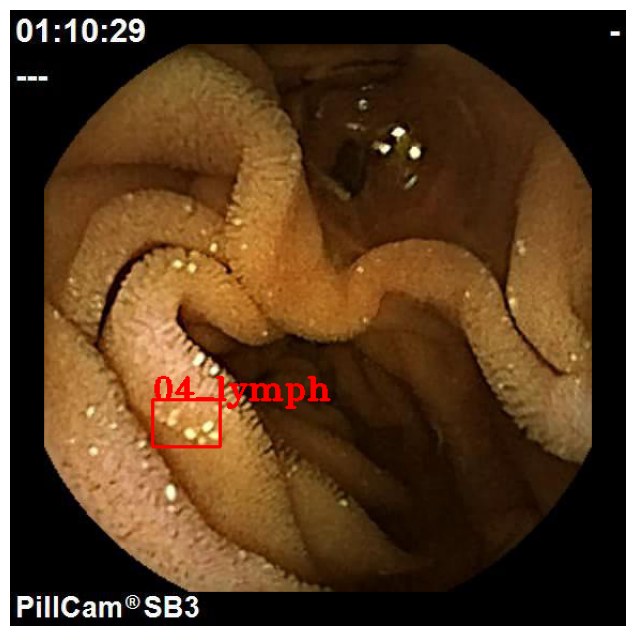

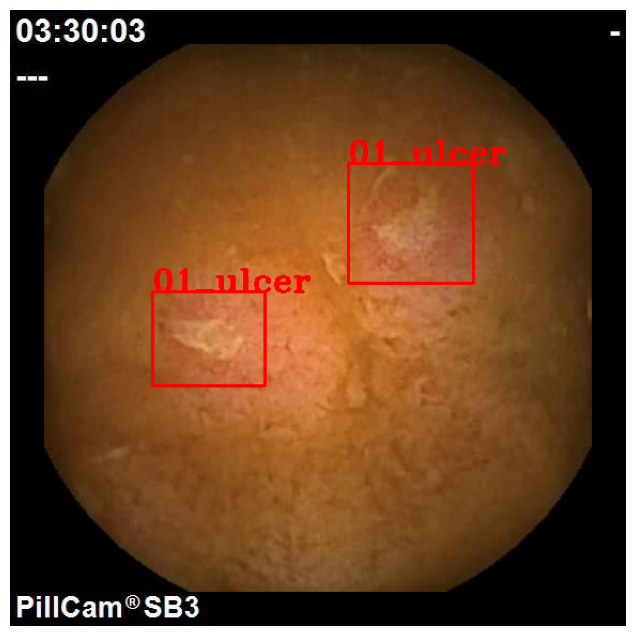

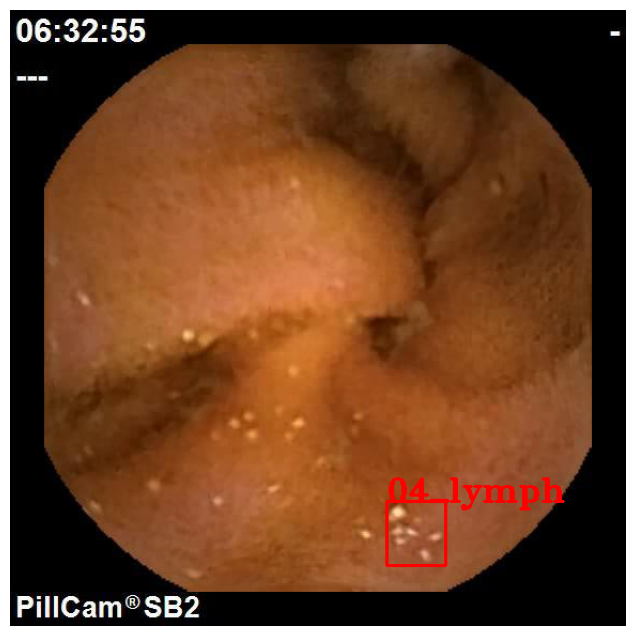

In [21]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for number in random.sample([1,2,3],3):
  boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
  img = images[number].permute(1,2,0).cpu().numpy()
  labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  for i in range(len(boxes)):
      img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
      #print(le.inverse_transform([labels[i]-1])[0])
      #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
      img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

  ax.set_axis_off()
  ax.imshow(img)



# Train

In [22]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [23]:
# 모델에 사용되는 모든 입력 Tensor들에 대해 input = input.to(device) 을 호출해야 합니다.
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs = 2

In [24]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in tqdm(train_data_loader):
        # to 메소드를 활용해 gpu로 옮긴다. Data to GPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Label classification, BoundingBox Regression의 Loss 값이 Ditcionary 형태로 나온다.
        loss_dict = model(images, targets)

        # Dict 형태의 loss_dict에서 .values()로 key:values에서 values를 가져온다.
        losses = sum(loss for loss in loss_dict.values())
        
        # losses를 print해보면 tensor()로 감싸져 있다. .item()으로 숫자만 가져오자.
        loss_value = losses.item()

        # loss_hist에 loss_value를 저장한다.
        loss_hist.send(loss_value)

        # optimizer 업데이트
        optimizer.zero_grad() # 1. 기울기 0으로 초기화
        losses.backward()  # 2. 역전파
        optimizer.step() # 3. 업데이트

        # 10번마다 loss값 출력
        if itr % 100 == 0:
            print(f"Iteration #{itr} loss: {loss_hist.value}")

        itr += 1
        
        # !!!REMOVE THIS!!!
        #break
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    print("Saving epoch's state...")
    torch.save(model.state_dict(), f"C:/A/lesionData/data_coco/weights/model_state_epoch_{epoch}.pth")

 18%|█▊        | 100/571 [02:42<08:02,  1.02s/it]

Iteration #100 loss: 0.3794815613570237


 35%|███▌      | 200/571 [04:25<06:19,  1.02s/it]

Iteration #200 loss: 0.3658225888526579


 53%|█████▎    | 300/571 [06:09<04:37,  1.02s/it]

Iteration #300 loss: 0.34490548495118883


 70%|███████   | 400/571 [07:52<02:56,  1.03s/it]

Iteration #400 loss: 0.32995192079302244


 88%|████████▊ | 500/571 [09:35<01:13,  1.03s/it]

Iteration #500 loss: 0.3190752222538139


100%|██████████| 571/571 [10:48<00:00,  1.14s/it]


Epoch #0 loss: 0.3119766243353863
Saving epoch's state...


  5%|▌         | 29/571 [00:29<09:15,  1.02s/it]

Iteration #600 loss: 0.2587204141071892


 23%|██▎       | 129/571 [02:12<07:32,  1.02s/it]

Iteration #700 loss: 0.23921954477635007


 40%|████      | 229/571 [03:54<05:53,  1.03s/it]

Iteration #800 loss: 0.24108684181236503


 58%|█████▊    | 329/571 [05:37<04:19,  1.07s/it]

Iteration #900 loss: 0.24437343348429927


 75%|███████▌  | 429/571 [07:20<02:25,  1.03s/it]

Iteration #1000 loss: 0.24503125494106198


 93%|█████████▎| 529/571 [09:03<00:43,  1.03s/it]

Iteration #1100 loss: 0.2441504311672915


100%|██████████| 571/571 [09:46<00:00,  1.03s/it]


Epoch #1 loss: 0.24317205302397615
Saving epoch's state...


# valid

In [21]:
images, targets, image_ids = next(iter(valid_data_loader))

In [22]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [23]:
targets

[{'boxes': tensor([[358.7576, 241.5584, 411.1385, 292.6407]], device='cuda:0',
         dtype=torch.float64),
  'labels': tensor([4], device='cuda:0'),
  'image_id': tensor([1412], device='cuda:0'),
  'area': tensor([2675.7368], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[154.4911, 393.4911, 233.7811, 482.2485]], device='cuda:0',
         dtype=torch.float64),
  'labels': tensor([3], device='cuda:0'),
  'image_id': tensor([4238], device='cuda:0'),
  'area': tensor([7037.5742], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[282.0106, 161.2540, 340.2116, 208.8730]], device='cuda:0',
         dtype=torch.float64),
  'labels': tensor([3], device='cuda:0'),
  'image_id': tensor([26], device='cuda:0'),
  'area': tensor([2771.4734], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[205.4273, 168.2819, 321.7269, 286.7841],
          [ 88.2467, 340.5286, 285.6035, 488.1057]], device='cuda:0'

In [24]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
#permute() : 모든 차원의 순서를 재배치. 이렇게 바뀐 순서를 다시 원래대로 돌려주기 위해 permute함수가 사용된 것이다.
sample = images[0].permute(1,2,0).cpu().numpy()

In [25]:
# nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수라고 한다.
# .eval() 함수는 evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수인 셈이다.
# model.eval()의 역할은 약간 다르다. 현재(2019년) 시점에서는 모델링 시 training과 inference시에 다르게 동작하는 layer들이 존재한다. 예를 들면, Dropout layer는 학습시에는 동작해야하지만, inference시에는 동작하지 않는 것과 같은 예시를 들 수 있다. BatchNorm같은 경우도 마찬가지다.
# 사실상 model.eval()는 이런 layer들의 동작을 inference(eval) mode로 바꿔준다는 목적으로 사용된다. 따라서, 우리가 보통 원하는 모델의 동작을 위해서는 위의 두 가지를 모두 사용해야하는 것이 맞다.

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


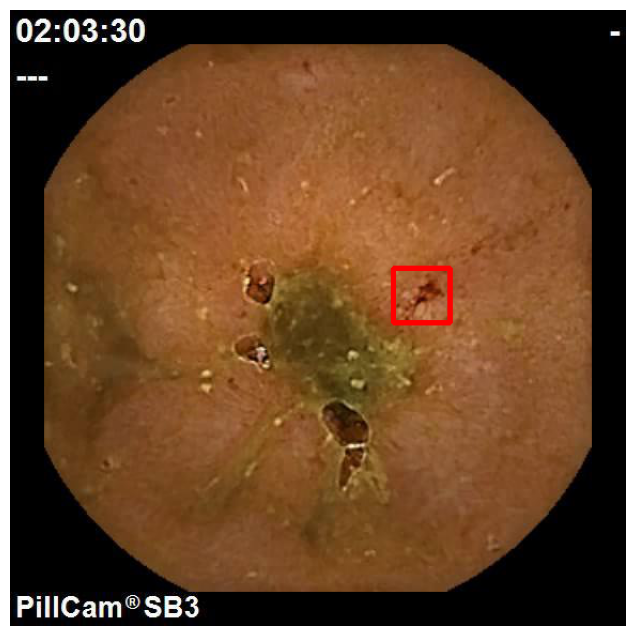

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)